In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from matplotlib.widgets import Slider, RadioButtons
from datetime import datetime        
from matplotlib.patches import Path, PathPatch


In [120]:
class MeteoMap() :
    
    def __init__(self, start, end) -> None:
       
        day_list = np.load('time2.npy')
       
        if start not in day_list  or  end not in day_list:
            
            raise ValueError('day not in :' + str(day_list))

        MeteoMap.start = start
        MeteoMap.end = end
        MeteoMap.pred = np.load('ypred.npy')
        MeteoMap.meas = np.load('result.npy')
        MeteoMap.day_list = day_list.tolist()
        MeteoMap.weights = np.load('param.npy')
        MeteoMap.parameters = ['tavg', 'tmin' ,'tmax', 'wdir' ,'wspd', 'pres']
    
    
    def get_station_list(self) :

        return np.load('stations.npy')

    def get_stations_coordinates(self, stations) : 
        
        long, lat = np.load('long.npy'), np.load('lat.npy')
        list_station = self.get_station_list().tolist()
        index_stations = [list_station.index(station) for station in stations]
        long_stations = [long[k] for k in index_stations]
        lat_stations = [lat[k] for k in index_stations]
        
        return np.array(long_stations), np.array(lat_stations)
    
    
    def get_stations_prediction_data(self, stations): 
       
        weights = self.weights
        list_station = list(self.get_station_list())
        day_list = self.day_list
        index_stations = [list_station.index(station) for station in stations]
        index_time = [day_list.index(self.start), day_list.index(self.end)]
        data = [[self.pred[time][idx_station*6:(idx_station+1)*6]*weights[1]+weights[0] for time in range(*index_time)] for idx_station in index_stations]
        
        return np.array(data)
    
    def get_stations_measured_data(self, stations): 
       
        weights = self.weights
        list_station = list(self.get_station_list())
        day_list = self.day_list
        index_stations = [list_station.index(station) for station in stations]
        index_time = [day_list.index(self.start), day_list.index(self.end)]
        data = [[self.meas[time][idx_station*6:(idx_station+1)*6] for time in range(*index_time)]*weights[1]+weights[0] for idx_station in index_stations]
        
        return np.array(data)

    def plot_stations_prediction_data(self, stations, parameter) : 
        
        """
        Data date range corresponds to map start & end date 
        
        """
        
        prediction = self.get_stations_prediction_data(stations)
        measured = self.get_stations_measured_data(stations)

        shape = len(stations)
        param = self.parameters
        i = param.index(parameter)
        
        fig, ax = plt.subplots(shape//2, 2, figsize = (12, shape*4))
        start_index = self.day_list.index(self.start)
        end_index = self.day_list.index(self.end)

        
        for k in range(shape) : 
            
            ax[k//2][k%2].plot(self.day_list[start_index:end_index],prediction[k][:,i], '-+',lw = 0.3, label = 'prediction')
            ax[k//2][k%2].plot(self.day_list[start_index:end_index], measured[k][:,i], lw = 0.3, label = 'reality')
            ax[k//2][k%2].set_title(stations[k])
            ax[k//2][k%2].set_xlabel('time')
            ax[k//2][k%2].set_ylabel(parameter)
            ax[k//2][k%2].legend()

       
        # rax = plt.axes([0., 0.6, 0.1, 0.1])
        #radio_button = RadioButtons(rax,param, activecolor='w')
       
        #def change_param(label):
        #    print('ahh')
        #    for k in range(shape) : 
        #        ax[k//2][k%2].plot(result[k][2000:2100,param.index(label)])
                
        #radio_button.on_clicked(change_param)
    
    def map_prediction(self, parameter, day : datetime) : 
        
        start_index = self.day_list.index(self.start)
        end_index = self.day_list.index(self.end)
        
        if self.day_list.index(day)-start_index <= 0 or self.day_list.index(day)-end_index >= 0 :
            raise Exception("the date must be within the map's date range")
        
        idx_day = self.day_list.index(day)-start_index
        stations = self.get_station_list().tolist()
        i = self.parameters.index(parameter)
        data = self.get_stations_measured_data(stations)[:, idx_day, i]
        data_pred = self.get_stations_prediction_data(stations)[:, idx_day, i]


        long, lat = self.get_stations_coordinates(stations)

        grid_x, grid_y = np.meshgrid(np.linspace(long.min(), 10, 70), 
                            np.linspace(lat.min()-1, lat.max()+1, 70))

        interpolate_data = interpolate.griddata((long,lat), data, (grid_x, grid_y), method='nearest')
        interpolate_data_pred = interpolate.griddata((long,lat), data_pred, (grid_x, grid_y), method='nearest')

        fig, ax = plt.subplots(2, figsize = (6,7))
        
        m = Basemap(-10, 40, 15, 60,
                    resolution='i', ax=ax[0])
        m2 = Basemap(-10, 40, 15, 60,
                    resolution='i', ax=ax[1])
        t1 = ax[0].contourf(grid_x, grid_y,interpolate_data, cmap = 'coolwarm', levels = 150)
        t2 = ax[1].contourf(grid_x, grid_y,interpolate_data_pred, cmap = 'coolwarm', levels = 150)
        
        fig.colorbar(t1, ax=ax[0], label = parameter)
        fig.colorbar(t2, ax=ax[1], label = parameter)

        
        m.readshapefile('ne_10m_admin_0_countries_fra', 'fr', drawbounds=False)

        ##getting the limits of the map:
        x0,x1 = -10, 15
        y0,y1 =  40, 60
        map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])
        map = np.array(m.fr[582])
        ##combining with map edges
        polys = [map]+[map_edges]
        ##creating a PathPatch
        codes = [
            [Path.MOVETO] + [Path.LINETO for p in p[1:]]
            for p in polys
        ]

        polys_lin = [v for p in polys for v in p]
        codes_lin = [c for cs in codes for c in cs]
        path = Path(polys_lin, codes_lin)
        patch = PathPatch(path,facecolor='peru', lw=0)

        ##masking the data:
        ax[0].add_patch(patch)

        ##combining with map edges
        polys2 = [m.fr[582]]+[map_edges]
        ##creating a PathPatch
        codes2 = [
            [Path.MOVETO] + [Path.LINETO for p in p[1:]]
            for p in polys2
        ]
        polys_lin2 = [v for p in polys2 for v in p]
        codes_lin2 = [c for cs in codes2 for c in cs]
        path2 = Path(polys_lin2, codes_lin2)
        patch2 = PathPatch(path2,facecolor='peru', lw=0)


        ##masking the data:
        ax[1].add_patch(patch2)
        m.drawlsmask(land_color = (0,0,0,0), 
                    ocean_color="cornflowerblue", zorder = 1)
        m.drawcoastlines(linewidth=0.6)
        m.drawcountries(linestyle='--', color = 'k', linewidth = 0.5)

        m2.drawlsmask(land_color = (0,0,0,0),ocean_color="cornflowerblue", zorder = 2)
        m2.drawcoastlines(linewidth=0.6)
        m2.drawcountries(color = 'k', linewidth = 0.5, linestyle='--')

       
        
        ax[0].set_title('Carte Réelle')
        ax[1].set_title('Carte Prédite')
        ax[0].scatter(long, lat, s = 8,  c = data)
        ax[1].scatter(long, lat, s = 8, c = data_pred)

        plt.show()
    
    def plot_statistics(self, parameter):
       
        stations = self.get_station_list()
        start_index = self.day_list.index(self.start)
        end_index = self.day_list.index(self.end)
        i = self.parameters.index(parameter)
        
        prediction = self.get_stations_prediction_data(stations)[:,:,i]
        measured = self.get_stations_measured_data(stations)[:,:,i]
        
       
        
        difference = measured-prediction
        std = np.std(difference, axis = 0)
        mean = np.mean(difference, axis = 0)
        
        segment_mean = [mean[k*10:(k+1)*10] for k in range(len(mean)//10)]
        std_mean = np.std(segment_mean, axis = 1)
        fig, ax = plt.subplots(2)
        
        ax[0].plot(self.day_list[start_index:end_index], std, lw = 0.3, label = 'std')
        ax[0].plot(self.day_list[start_index:end_index], mean,lw = 0.3, label = 'mean')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel(parameter)
        ax[0].legend()
        
        ax[1].loglog(std_mean, '-+', lw = 0.6, markersize = 3, label = 'std')
        ax[1].set_xlabel('time_interval')
        ax[1].set_ylabel(parameter+'_std')
        ax[1].legend()
 


In [121]:
map = MeteoMap(start = datetime(2017, 1, 1), end  = datetime(2020, 1,26))

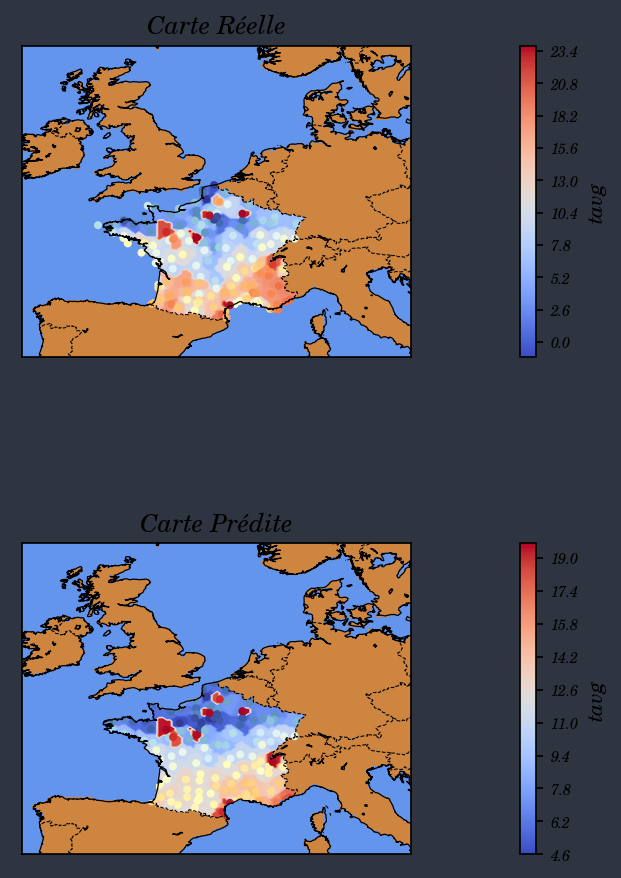

In [122]:
map.map_prediction('tavg', datetime(2018, 1, 1))

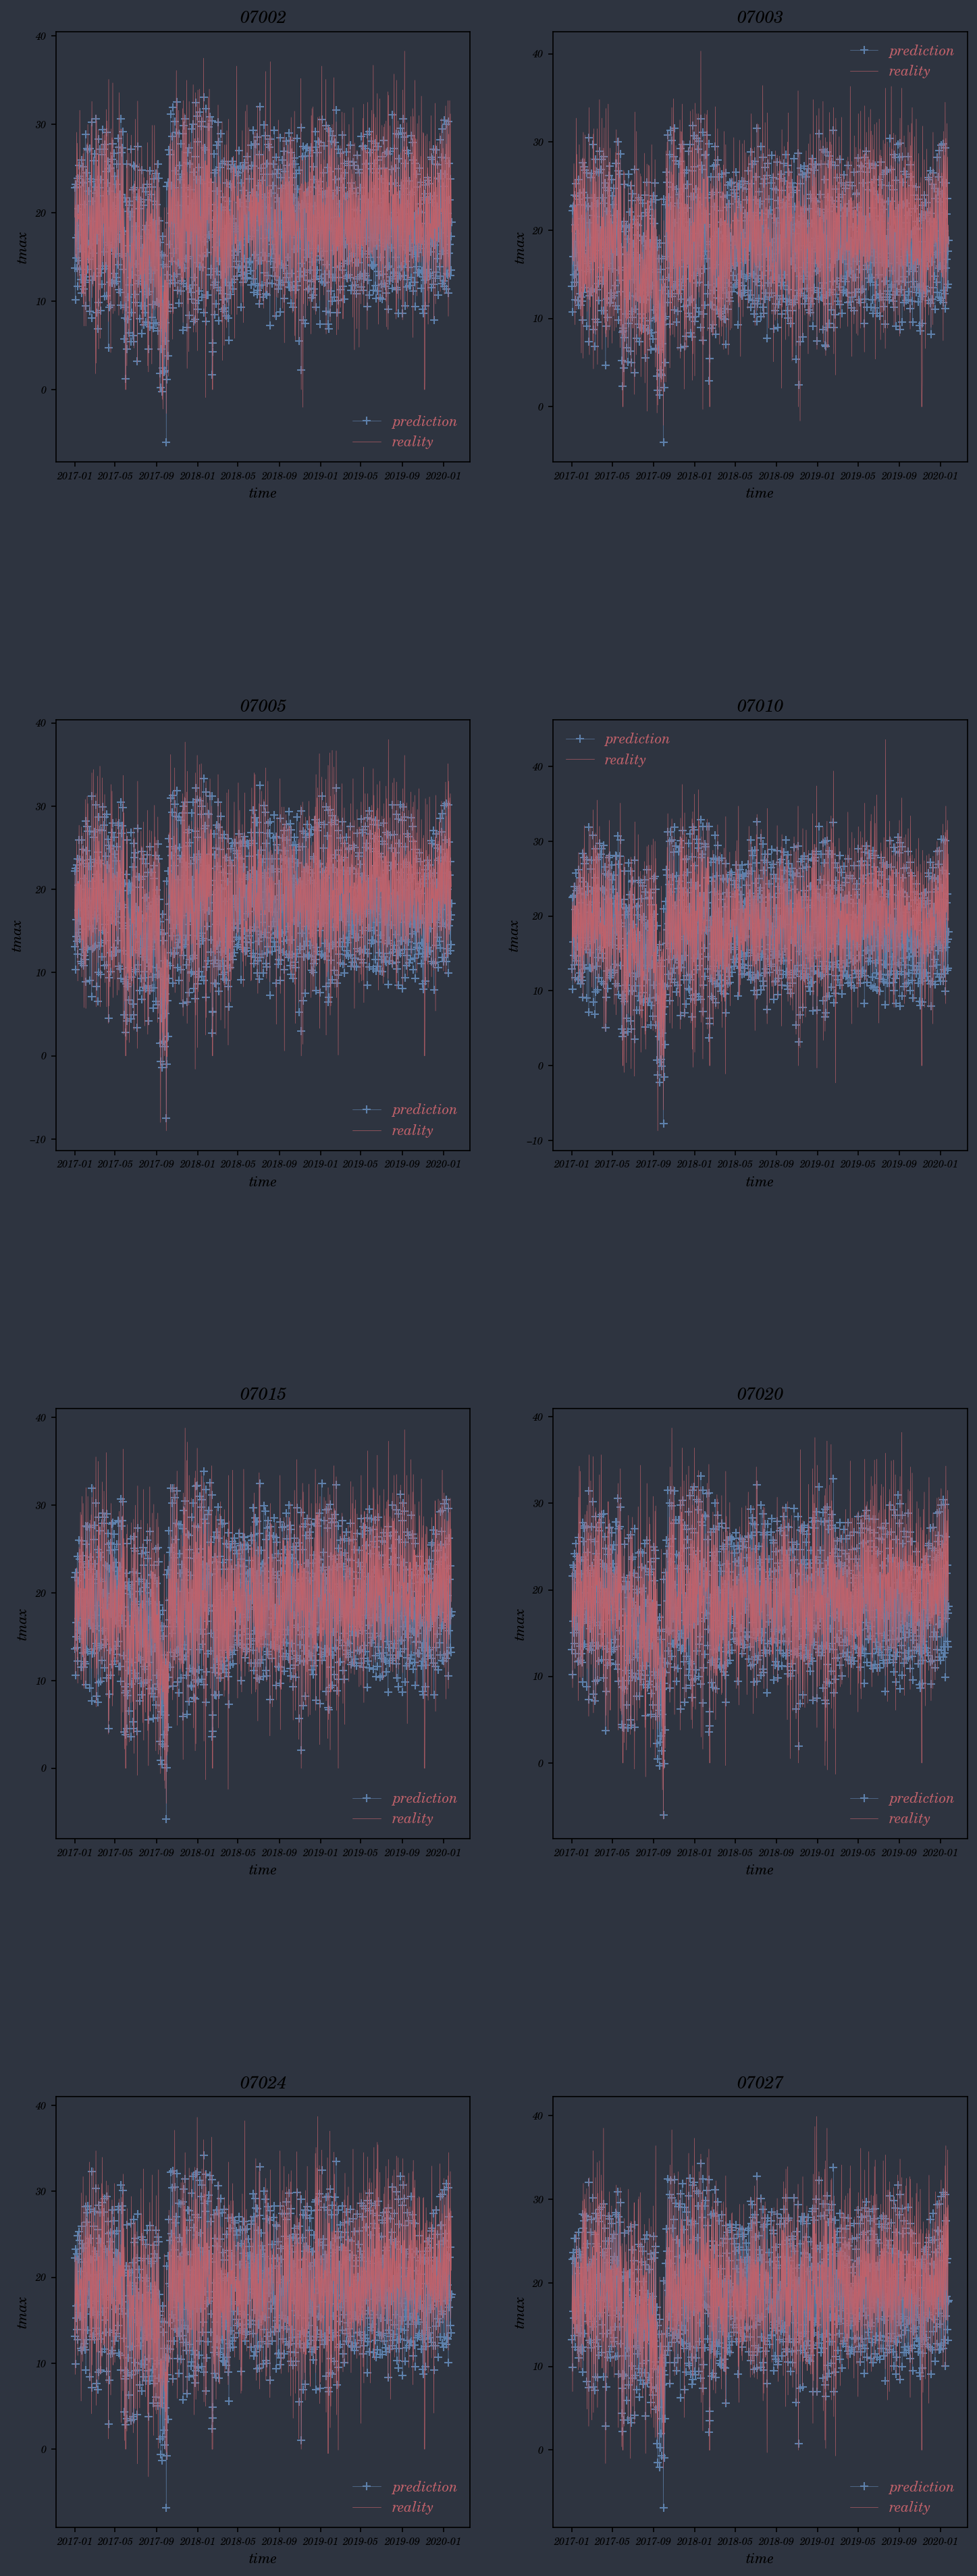

In [76]:
map.plot_stations_prediction_data(['07002', '07003', '07005', '07010', '07015', '07020', '07024',
       '07027'], 'tmax')

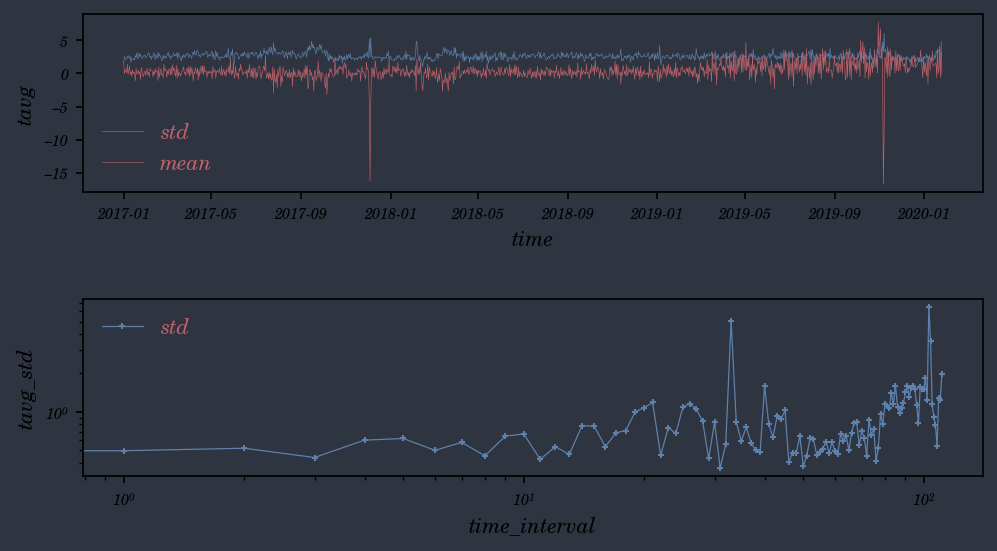

In [110]:
map.plot_statistics('tavg')